In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [21]:
# Set up ipywidgets for interactive chart.
!jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets
from ipywidgets import interact, fixed

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Function for Effect Size Calculation

In [22]:
# Function to compute effect sizes
# Based on method in Nakagawa, S. and I.C. Cuthill. (2007). Biol. Rev. 82. pp. 591-605.

import math

def cohensd(t, df, n1, n2):
    d = ( t * (n1+n2) ) / (math.sqrt(n1*n2) * math.sqrt(df))
    se = math.sqrt( ((n1+n2-1)/(n1+n2-3)) * ( (4/(n1+n2)) * (1 + (d**2)/8) ))
    return {'d': d, 'se': se, 'lower_ci': d-1.96*se, 'upper_ci': d+1.96*se}

### Functions to Visualize the Data

In [23]:
# Plot distributions of the data by subset. These are meant to be overlaid, so just show the KDE.
def plot_distributions(data, subset_col, display_col):
    for sub in data[subset_col].unique():
        subset=data[data[subset_col] == sub]
        sns.distplot(subset[display_col],hist=False, kde=True, label=sub)

In [24]:
# Plot distributions, using stacked violin plots, split by the values in y.
def plot_stacked_dists(x, y, data, scale = 'count'):
    # Plot the distributions of ages across all sites. Extra hue_class column is a hacky solution to get seaborn 
    # to display half a violin plot.
    plt.figure()
    sns.set(style = 'whitegrid')
    vp_data = pd.DataFrame({'idx': data.index, x: data[x], y: data[y], 'hue_class': 0})
    vp_data['hue_class'].loc[-1] = 999
    ax_vp = sns.violinplot(y = y, x = x, data = vp_data, hue = 'hue_class', split = True, scale = scale)
    ax_vp.legend().remove()
    plt.show()

In [51]:
# Function to plot original and harmonized distributions together, by site.
def plot_dual_distributions(x, y, data_unharmonized, data_harmonized, scale = 'count'):
    # Plots two distibutions (e.g. harmonized and unharmonized data) as the two halves of stacked violin plots.
    plt.figure(figsize = (12,5))
    vp_data = pd.DataFrame({x: data_unharmonized[x], y: data_unharmonized[y], 'Legend': 'Unharmonized'})
    vp_data = vp_data.append(pd.DataFrame({x: data_harmonized[x], y: data_harmonized[y], 'Legend': 'Harmonized'}))
    ax_h_uh = sns.violinplot(y = y, x = x, data = vp_data, hue = 'Legend', split = True, scale = scale)
    #ax_h_uh.legend().remove()
    plt.show()

In [48]:
# Plot a panel of figures useful for quick data exploration and verification.
def plot_panel(nucleus, data_unh, data_h):
    plt.figure()
    fig, axes = plt.subplots(ncols=2, nrows = 2, figsize = (13,4))
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
    
    # Plot nucleus volume by Age and TBV: data1
    axes[0,0].title.set_text("Unharmonized")
    sns.scatterplot('Age', nucleus, data = data_unh, hue = "DX", ax=axes[0,0])
    sns.regplot('Age', nucleus, data = data_unh, scatter = False, ax=axes[0,0])
    sns.scatterplot('TBV', nucleus, data = data_unh, hue = "DX", ax=axes[1,0])
    sns.regplot('TBV', nucleus, data = data_unh, scatter = False, ax=axes[1,0])
       
    axes[0,1].title.set_text("Harmonized")
    # Plot nucleus volume by Age and TBV: data2
    sns.scatterplot('Age', nucleus, data = data_h, hue = "DX", ax=axes[0,1])
    sns.regplot('Age', nucleus, data = data_h, scatter = False, ax=axes[0,1])
    sns.scatterplot('TBV', nucleus, data = data_h, hue = "DX", ax=axes[1,1])
    sns.regplot('TBV', nucleus, data = data_h, scatter = False, ax=axes[1,1])
    
    # Plot the two distributions together
    plot_dual_distributions(x=nucleus, y = 'Site', data_unharmonized = data_unh, data_harmonized = data_h, scale = 'count')

In [27]:
# Function to plot fitted values against residuals
# This relies on internal structure of the models. For now, it's the same for the linear regression and linear mixed models.
#def plot_fitted_vs_residual(models, ex_data, x_fitted_col, y_resid_col, display_col, hue_col, title_add = None):
def plot_fitted_vs_residual(models, ex_data, display_col, hue_col, title_add = None):
    plt.figure(figsize = (12,8))
    fitted_y = models[display_col].fittedvalues
    resid = models[display_col].resid
    # The following is not ideal. Need to revisit this solution.
    fit_resid_df = pd.DataFrame({'Residual': resid, 'Fitted_Value': fitted_y, 'Site': ex_data['Site'], 'DX': ex_data['DX']})
    ax = sns.scatterplot(fitted_y, resid, hue = hue_col, data=fit_resid_df)
    ax.set_title('Fitted vs. Residual Plot for ' + display_col + title_add)
    ax.set(xlabel = 'Fitted', ylabel = 'Residual')
    ax.legend().remove()
    plt.show()  

## Read data and drop rows with missing values for age, examine structure

In [28]:
data = pd.read_csv("../data/data_trimmed_allsites.csv", index_col=0)
#data = pd.read_csv("../data/data_trimmed.csv", index_col=0)

# Age is missing in some rows, but is needed for modelling. Drop those rows
complete_rows = data['Age'].notna()
NA_rows = ~complete_rows
data = data[complete_rows]

## Mask features that failed segmentation QC

In [29]:
# QC columns are of the form L_str. Volume data is in L_str_vol
QC_cols = ['L_str', 'L_GP', 'L_thal', 'R_str', 'R_GP', 'R_thal']
features = [QCc + '_vol' for QCc in QC_cols]

QC_failed = data[QC_cols] <= 0.5
data[features] = data[features].mask(QC_failed.values)

## Get harmonized subcortical volume data from neuroCombat

In [30]:
# Read in harmonized features from R output
harmonized_features = pd.read_csv("harmonized_masked.csv", index_col=0)

### Determine Effect of Diagnosis: Linear Models with ComBat Harmonized Data


In [31]:
# Linear regression on ComBat harmonized data
from statsmodels.formula.api import ols

models = pd.Series(dtype='object')
model_params = pd.Series(dtype = 'object')
model_es = []

for nucleus in harmonized_features.columns[:-5]:        # Don't include last (covariate) columns
    models[nucleus] = ols(formula = nucleus + ' ~ DX + Age + Sex + TBV', data = harmonized_features).fit()
#    print(models[nucleus].summary())
    model_params[nucleus] = models[nucleus].params

    # Get effect size, being sure to drop rows with NA for age.
    n_control = sum(data['DX'] == 'Control')
    n_ASD = models[nucleus].nobs - n_control
    model_es.append(cohensd(t  = models[nucleus].tvalues['DX[T.Control]'], 
                                df = models[nucleus].df_resid, 
                                n1 = n_control,
                                n2 = n_ASD))

## Compute Linear Regression on Unharmonized Data

In [32]:
# Linear regression on unharmonized data
models_unh = pd.Series(dtype='object')
model_unh_params = pd.Series(dtype = 'object')
model_unh_es = []

for nucleus in features:
    models_unh[nucleus] = ols(formula = nucleus + ' ~ DX + Age + Sex + TBV + Site', data = data).fit()
#    print(models_unh[nucleus].summary())
    model_unh_params[nucleus] = models_unh[nucleus].params
    
    # Get effect size, being sure to drop rows with NA for age.
    n_control = sum(data['DX'] == 'Control')
    n_ASD = models_unh[nucleus].nobs - n_control
    model_unh_es.append(cohensd(t  = models_unh[nucleus].tvalues['DX[T.Control]'], 
                                    df = models_unh[nucleus].df_resid, 
                                    n1 = n_control,
                                    n2 = n_ASD))

## Linear Mixed Model on the Raw Data
An alternative analysis is to run a linear mixed model on the raw (unharmonized) data, with site as a random effect. 

In [33]:
# Linear mixed model, site as random factor
import statsmodels.formula.api as smf

lm_models = pd.Series(dtype='object')
lm_model_params = pd.Series(dtype = 'object')
lm_model_es = []

for nucleus in features:
    lm_models[nucleus] = smf.mixedlm(nucleus + " ~ DX + Age + Sex + TBV", data, groups = data["Site"], missing='drop').fit()
    lm_model_params[nucleus] = lm_models[nucleus].params
    
    # Get effect size, being sure to drop rows with NA for age.
    n_control = sum(data['DX'] == 'Control')
    n_ASD = lm_models[nucleus].nobs - n_control
    lm_model_es.append(cohensd(t  = lm_models[nucleus].tvalues['DX[T.Control]'], 
                          df = lm_models[nucleus].df_resid, 
                          n1 = n_control,
                          n2 = n_ASD))

# <p style="text-align: center;">Harmonizing Multi-Site Structural MRI Datasets</p>

### <p style="text-align: center;">David MacDonald</p>

## Multi-site MRI


 * Neuroimaging data, such as MRI, is time-consuming and very costly to collect, but rich in information.
 * Multi-site, open data allows for much larger sample sizes and much greater statistical power in MRI studies, while distributing the cost across many research centers.



### <p style="text-align: center;">HOWEVER . . .</p>

 ### <p style="text-align: center;">HOWEVER . . .</p>
 
 * Differences between scans due to technical factors can overwhelm those due to biological factors
 ### <p style="text-align: left;">This introduces VARIABILITY, and . . . </p>

  

 
 
 
 * Different sites likely sample different populations
 
 ### <p style="text-align: left;">Which introduces BIAS. . . </p>

## Purpose

### The Context
Examining the volume of thalamus, globus pallidus, striatum in ASD, using the [ABIDE](http://fcon_1000.projects.nitrc.org/indi/abide/) dataset

### Multi-Site Data Harmonization
 * Use linear mixed-effect models.
 * Use the open source [neuroCombat](https://github.com/Jfortin1/ComBatHarmonization) library, which was originally intended to mitigate batch effects in genetic studies, but has since been adapted to work with neuroimaging data.


## My (Relevant) Background

* 1st year M.Sc. student at McGill University
* Using structural MRI to study subcortical structures in Autism Spectrum Disorders

* Prior neuroscience work in a wet lab: IHC and molecular
* Experience using Excel, SPSS point-and-click interface

* Some experience with:
    * bash
    * programming (learning R, C++ a *long* time ago)
    * HPC through Compute Canada

* Minimal experience with:
    * git and github


## Workflow


<center><img src="workflow_prosp.png" alt="Image" style="width: 1500px" align="center"/></center>

## Workflow

<center><img src="workflow_actual.png" alt="Image" style="width: 1500px" align="center"/></center>

## Exploration and Visualization
### Age Distributions

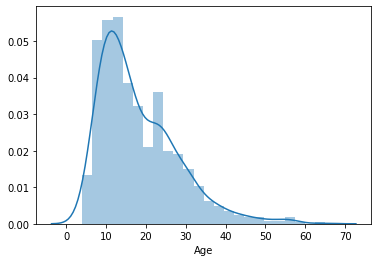

In [34]:
sns.distplot(data['Age'])

### Age Distributions by Site

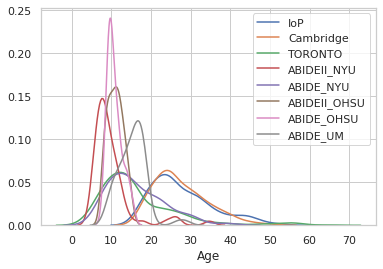

In [57]:
plot_distributions(data, "Site", "Age")

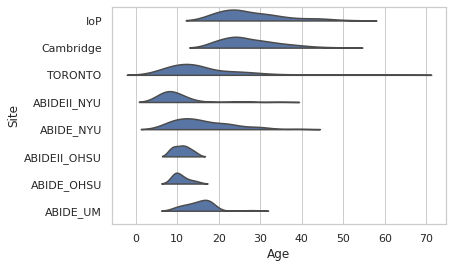

In [37]:
plot_stacked_dists(x = 'Age', y = 'Site', data = data)

### Harmonized vs. Unharmonized

In [49]:
interact(plot_panel, nucleus = features, data_unh = fixed(data), data_h=fixed(harmonized_features))

interactive(children=(Dropdown(description='nucleus', options=('L_str_vol', 'L_GP_vol', 'L_thal_vol', 'R_str_v…

<function __main__.plot_panel(nucleus, data_unh, data_h)>

### Fitted Values vs. Residuals Plots

In [55]:
interact(plot_fitted_vs_residual, models = fixed(models), ex_data = fixed(data), display_col = features,  hue_col = ['DX', 'Site'], title_add = fixed(' Combat Harmonized Data'))

interactive(children=(Dropdown(description='display_col', options=('L_str_vol', 'L_GP_vol', 'L_thal_vol', 'R_s…

<function __main__.plot_fitted_vs_residual(models, ex_data, display_col, hue_col, title_add=None)>

## Results
<center><img src="forest_plot.png" alt="Forest Plot" style="width: 1500px" align="center"/></center>

 * Note: none of these effects were significant at $\alpha = 0.5$
 * No clear benefit in this dataset, potentially because:
     * Small number of features
     * Pooling across regions may not be helpful

## Open Science Tools

 * Git and GitHub

 * Python
     * Pandas for data manipulation
     * Seaborn for data visualization
     * Ipywidgets for interactive data visualization
     * Statsmodels for data analysis
 * R

 * bash scripting for batch-mode pipelines
 * Jupyter Notebooks
     * Interactive data exploration
     * Presentations with RISE

 * Virtualization with conda
 * Containerization with Docker

## Skills and Technologies

 * Linear mixed-effects modelling with statsmodels in python
 * [ComBat](https://github.com/Jfortin1/ComBatHarmonization) for harmonizing neuroimaging data
 
 Both were learned independently during BHS, with support of instructors and peers

## Relevance

 * With the increasing use of open datasets in neuroimaging, it is important to have tools to manage non-biological sources of variation in scans
 * No studies yet where ComBat has been used to harmonize multi-site subcortical volume / morphometry

## Further Work

 * **Extend to vertex-wise data**
 * Complete containerization of pipeline
 * Contribute missing features to the Python version of ComBat on GitHub
     * Handling missing values
     * Empirical Bayes: visualizing parameter distributions

## Questions?

## ComBat

#### Standard Linear Model
$$y_{roi,i} = \alpha_{roi} + X_{i} \beta_{roi} + \epsilon_{roi,i}$$



#### Add location and scale correction

 
$$y_{roi,site,i} = \alpha_{roi} + X_{site,i} \beta_{roi} + \gamma_{roi,site} + \delta_{roi,site} \epsilon_{roi,site,i}$$

 * Error terms may be drawn from different normal distributions at each site
 * Both additive ($\gamma$) and multiplicative ($\delta$) site effects
 * Site effects assumed *non-independent* across regions
     * Estimate $\gamma$ and $\delta$ using Empirical Bayes framework

#### Determine Error Term...

$$\epsilon_{roi,site,i} = \frac{y_{roi,site,i} - \alpha_{roi} - X_{site,i} \beta_{roi} - \gamma_{roi,site}}{\delta_{roi,site}}$$

#### and Remove Site Effects

$$y_{roi,site,i}^{ComBat} = \alpha_{roi} + X_{site,i} \beta_{roi} + \epsilon_{roi,site,i}$$